**XLNET Model to predict Sentiment of the comments in the YouTube dataset. 
The sentiment of the comments are classified into positive/negative/neutral**

In [ ]:
#importing the packages
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import transformers
from transformers import TFXLNetModel, XLNetTokenizer
import nltk
import re


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, 
                             roc_curve, f1_score, confusion_matrix,
                             classification_report)


In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#reading the file
data = pd.read_csv('comments.csv')
data.columns = [x.upper() for x in data.columns]

In [ ]:
#checking missing values
data.isna().sum()

UNNAMED: 0    0
VIDEO ID      0
COMMENT       1
LIKES         0
SENTIMENT     0
dtype: int64

In [ ]:
#droping the missing value
data.dropna(inplace=True)

In [ ]:
#pre-processing the comments
def clean_text(text):
    # remove urls
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    # remove puncutations
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    # remove tab
    text = re.sub('\t', ' ',  text)
    # remove multiple spaces
    text = re.sub(r" +", ' ', text)
    return text

In [ ]:
#pre-processing the comments
data['NEW_COMMENT'] = data['COMMENT'].apply(clean_text)

In [ ]:
#printing the comments after pre-processing
data.head()

,UNNAMED: 0,VIDEO ID,COMMENT,LIKES,SENTIMENT,NEW_COMMENT
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0,Let's not forget that Apple Pay in 2014 requir...
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0,Here in NZ 50 of retailers don t even have con...
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0,I will forever acknowledge this channel with t...
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0,Whenever I go to a place that doesn t take App...
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0,Apple Pay is so convenient secure and easy to ...


In [ ]:
#using xlnet pre-trained model
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(128,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), \
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), \
                  metrics=[
                           'accuracy'
                          ])

    return model

In [ ]:
xlnet = create_xlnet(xlnet_model)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:
#summary of the xlnet model
xlnet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 128)]             0         
                                                                 
 tfxl_net_model_3 (TFXLNetMo  TFXLNetModelOutput(last_  116718336
 del)                        hidden_state=(None, 128,            
                              768),                              
                              mems=((128, None, 768),            
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),            

In [ ]:

comments = data['NEW_COMMENT']
labels = data['SENTIMENT'].astype('int')
#splitting the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(comments, labels, \
                                                    test_size=0.25, \
                                                    random_state=0, \
                                                    stratify = labels)

In [ ]:
test = pd.DataFrame([x_test, y_test]).T
train = pd.DataFrame([x_train, y_train]).T

train.to_csv('train.csv')
test.to_csv('test.csv')

In [ ]:
def get_inputs(comments, tokenizer, max_len=128):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, \
                                  pad_to_max_length=True, \
                                  add_special_tokens=True) for t in comments]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)



In [ ]:
inp_tok, ids, segments = get_inputs(x_train, xlnet_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
fp = '/content/drive/MyDrive/certificate2_module_project/xlnet_checkpoint'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=fp,save_weights_only=True,
                                        monitor='val_loss',mode='auto',\
                                       save_best_only=True),\
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', \
                                     patience=2, min_delta=0.02, \
                                     restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
                                         factor=1e-6, patience=2, \
                                         verbose=0, mode='auto', \
                                         min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
#training the model
hist = xlnet.fit(x=inp_tok, y=y_train, \
                 epochs=6, batch_size=4, \
                 validation_split=.15, callbacks=callbacks)

Epoch 1/6
2934/2934 [==============================] - 524s 179ms/step - loss: 0.5711 - accuracy: 0.7755 - val_loss: 0.4534 - val_accuracy: 0.8242 - lr: 2.2000e-05
Epoch 2/6
2934/2934 [==============================] - 503s 172ms/step - loss: 0.3917 - accuracy: 0.8422 - val_loss: 0.5257 - val_accuracy: 0.8112 - lr: 2.3000e-05
Epoch 3/6
2934/2934 [==============================] - 512s 175ms/step - loss: 0.3010 - accuracy: 0.8832 - val_loss: 0.4137 - val_accuracy: 0.8484 - lr: 2.4000e-05
Epoch 4/6
2934/2934 [==============================] - 506s 173ms/step - loss: 0.2345 - accuracy: 0.9115 - val_loss: 0.5956 - val_accuracy: 0.8310 - lr: 2.5000e-05
Epoch 5/6
2934/2934 [==============================] - 499s 170ms/step - loss: 0.1887 - accuracy: 0.9320 - val_loss: 0.4868 - val_accuracy: 0.8363 - lr: 2.6000e-05
Epoch 6/6
2934/2934 [==============================] - 502s 171ms/step - loss: 0.1284 - accuracy: 0.9553 - val_loss: 0.5177 - val_accuracy: 0.8382 - lr: 2.0000e-05


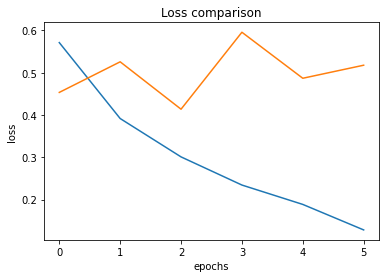

In [ ]:
#plotting the loss function
metrics = pd.DataFrame(hist.history)
plt.plot(metrics['loss'], label='training_loss')
plt.plot(metrics['val_loss'], label='validatoin_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss comparison')
plt.show()

inference

In [ ]:
test_inp_tok, test_ids, test_segments = get_inputs(x_test, xlnet_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#predicting on test set
preds = xlnet.predict(test_inp_tok, verbose=True)

144/144 [==============================] - 53s 354ms/step


In [ ]:
y_pred = np.argmax(preds,axis=1)

In [ ]:
#Classification report and confusion matrix using xlnet model on test set
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       598
           1       0.72      0.64      0.68      1130
           2       0.89      0.93      0.91      2874

    accuracy                           0.84      4602
   macro avg       0.79      0.77      0.78      4602
weighted avg       0.83      0.84      0.83      4602

[[ 448  112   38]
 [ 105  727  298]
 [  31  164 2679]]


In [ ]:
#saving the xlnet model
xlnet.save('/content/drive/MyDrive/certificate2_module_project/xlnet_model/trained_xlnet.h5')